Based on:
https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config IPCompleter.use_jedi = False

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import seaborn as sns
sns.set()

### First: Python tools for dates and times

# Resampling, Shifting, and Windowing

`conda install pandas-datareader`

In [7]:
%%script false --no-raise-error

!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD
!mv FremontBridge.csv ./data/FremontBridge.csv

In [145]:
data = pd.read_csv('./data/FremontBridge.csv', index_col='Date', parse_dates=True)
data = data.sort_index()
data.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0


In [146]:
data.describe().astype(int)

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
count,141400,141400,141400
mean,111,50,60
std,141,65,88
min,0,0,0
25%,14,6,7
50%,60,28,30
75%,145,68,74
max,1097,698,850


In [147]:
from dateutil import parser


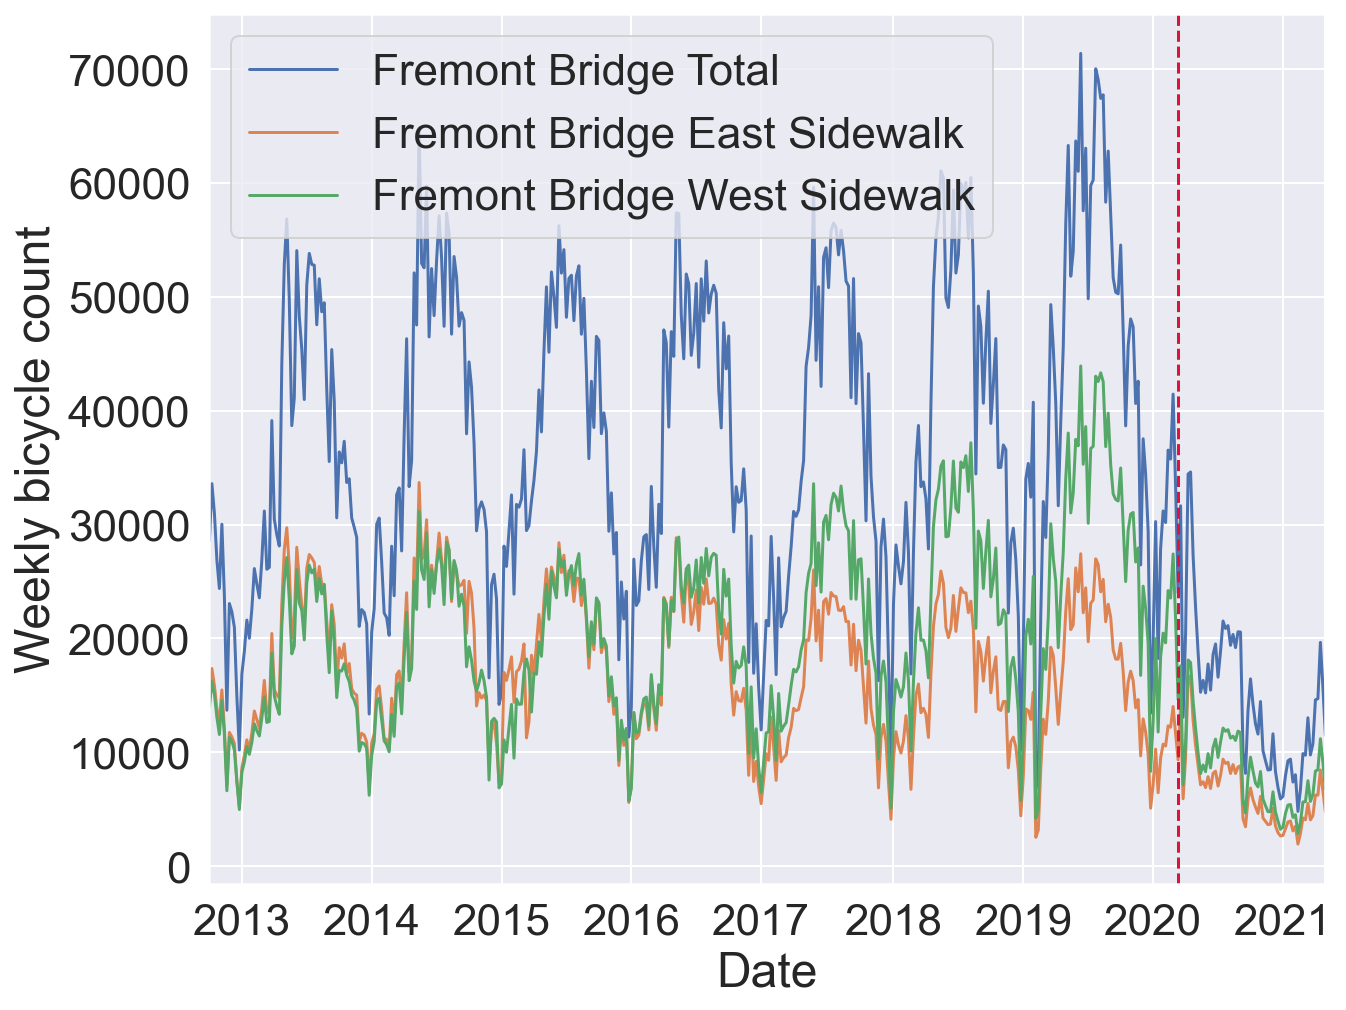

In [148]:
fig, ax = plt.subplots(figsize=(10,8))
weekly = data.resample('W').sum()
weekly.plot(ax=ax)
plt.ylabel('Weekly bicycle count');

date = parser.parse("15, March, 2020 at 12:00")

# Approximately when covid restrictions started:
plt.axvline(date, ls='--', c='crimson') 

### Wow, effects of COVID are clearly visible!

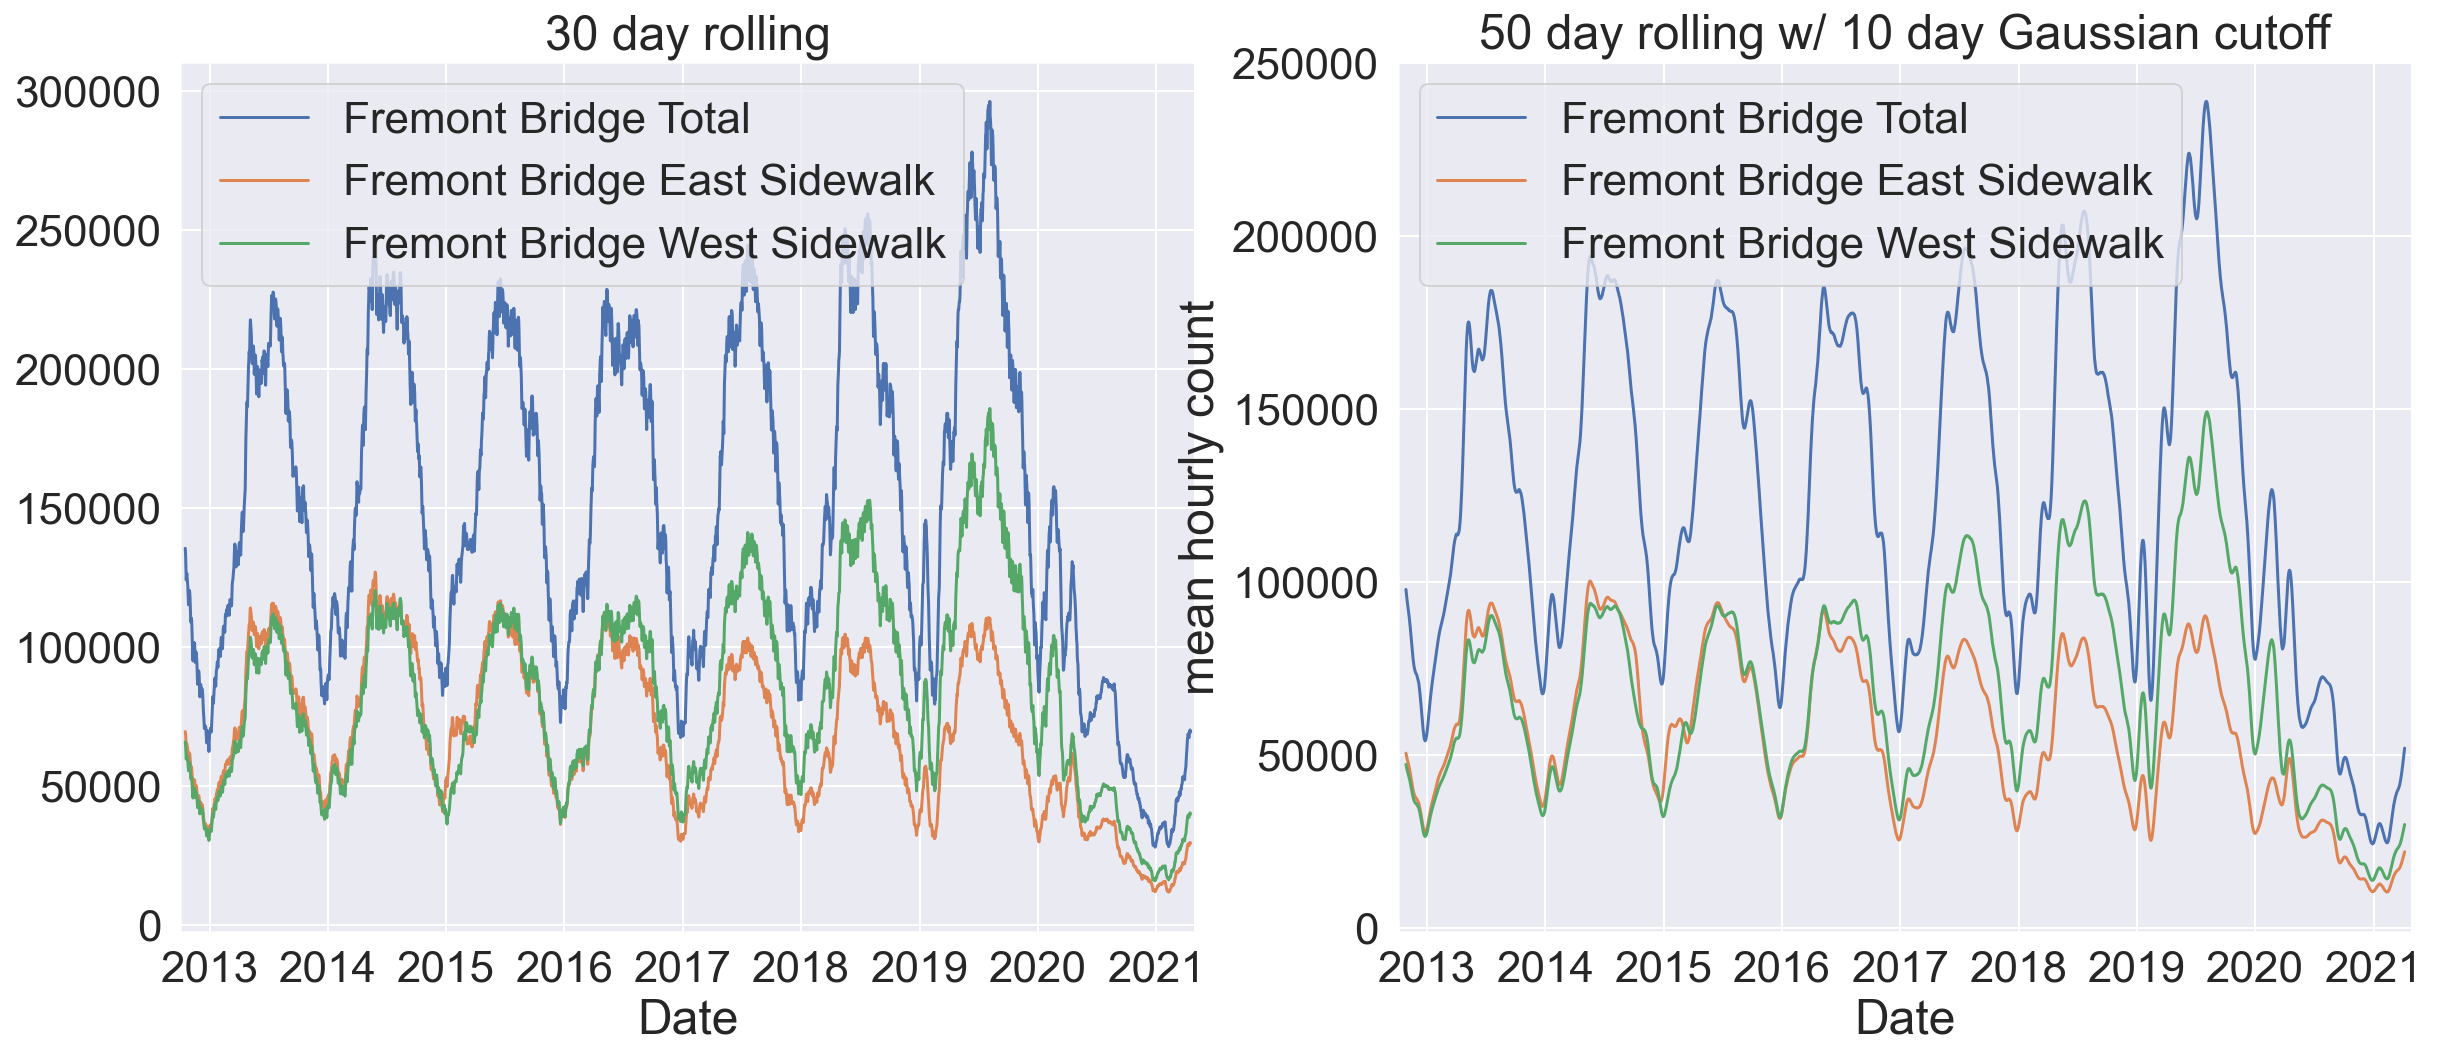

In [149]:
fig, axes = plt.subplots(ncols=2, figsize=(20,8))

axes[0].set_title('30 day rolling')
daily = data.resample('D').sum()
daily.rolling(30, center=True).sum().plot(ax=axes[0]) # 30 day rolling mean
plt.ylabel('mean hourly count');

axes[1].set_title('50 day rolling w/ 10 day Gaussian cutoff')
daily = data.resample('D').sum()
daily.rolling(50, center=True, win_type='gaussian').sum(std=10).plot(ax=axes[1]) # 30 day rolling mean
plt.ylabel('mean hourly count');

In [150]:
data

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0
...,...,...,...
2021-04-30 19:00:00,139.0,64.0,75.0
2021-04-30 20:00:00,65.0,27.0,38.0
2021-04-30 21:00:00,34.0,14.0,20.0


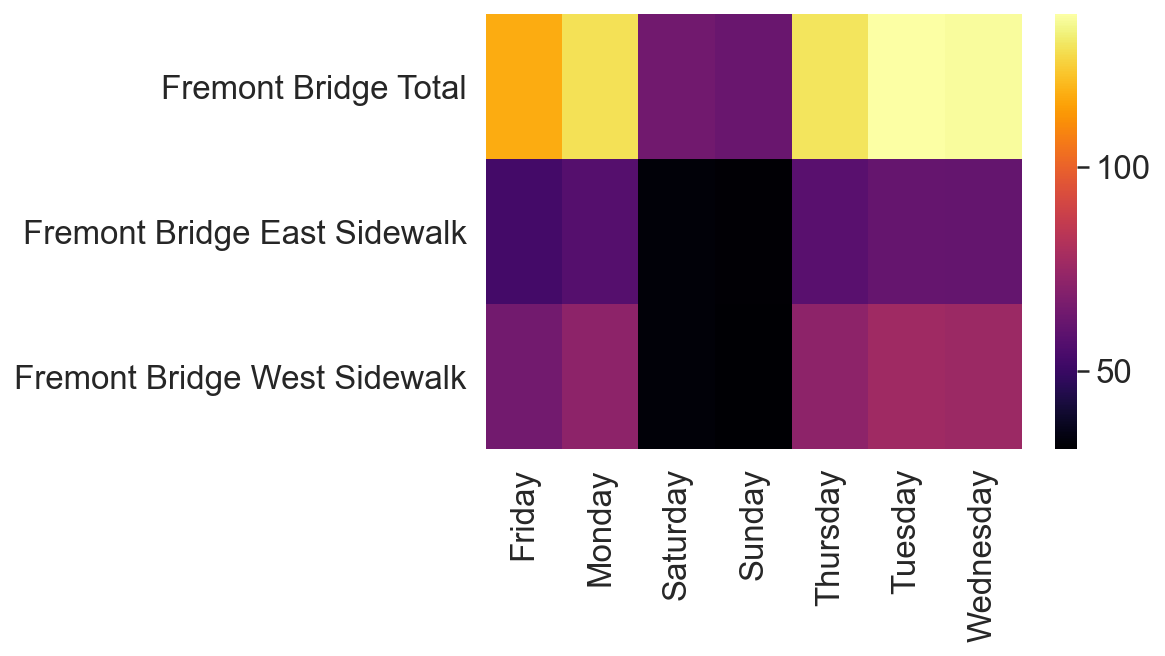

In [196]:
with sns.plotting_context('notebook', font_scale=1.5):
    sns.heatmap(data.groupby(data.index.day_name()).mean().T, cmap='inferno')
    plt.xlabel('')
    
# Hmm this is not sorted..
# .. see next figure for sorting example

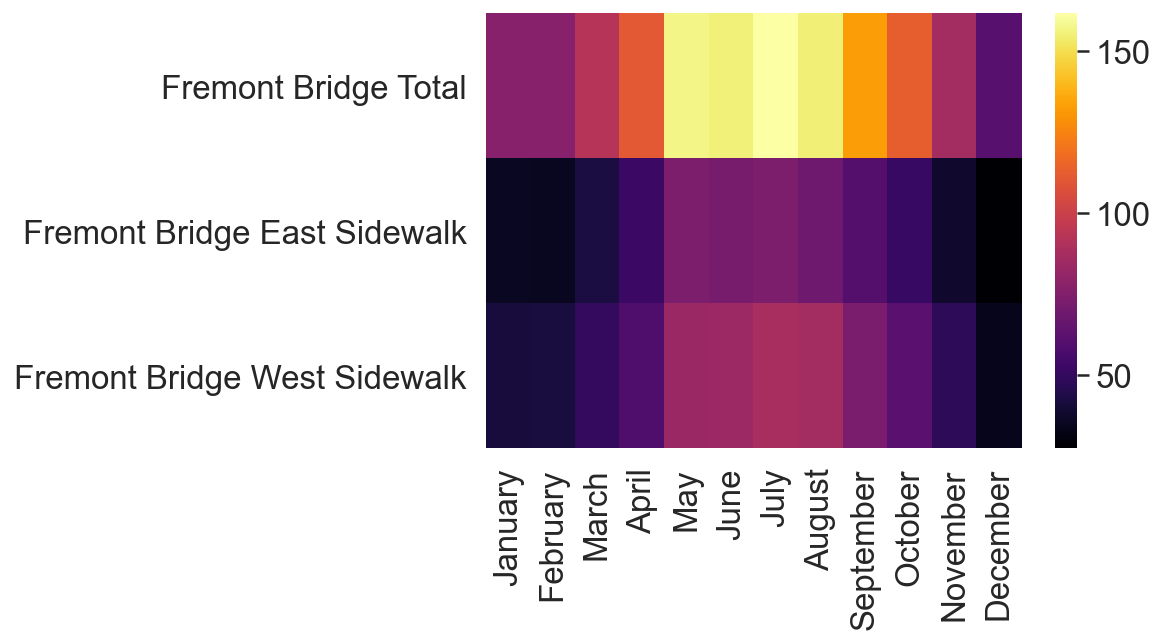

In [195]:
with sns.plotting_context('notebook', font_scale=1.5):

    
    data_preC19 = data[:'April, 2020'] # select unly up to covid
    mat = data_preC19.groupby(data_preC19.index.month_name()).mean() # groupby on months and sum
    cols_sorted = pd.to_datetime(mat.index.values + '2020').argsort() # sort the months chronologically
    mat = mat.reindex(mat.index[cols_sorted])

    sns.heatmap(mat.T, cmap='inferno')
    plt.xlabel('')

In [232]:
data.index.hour

Int64Index([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,
            ...
            14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
           dtype='int64', name='Date', length=141422)

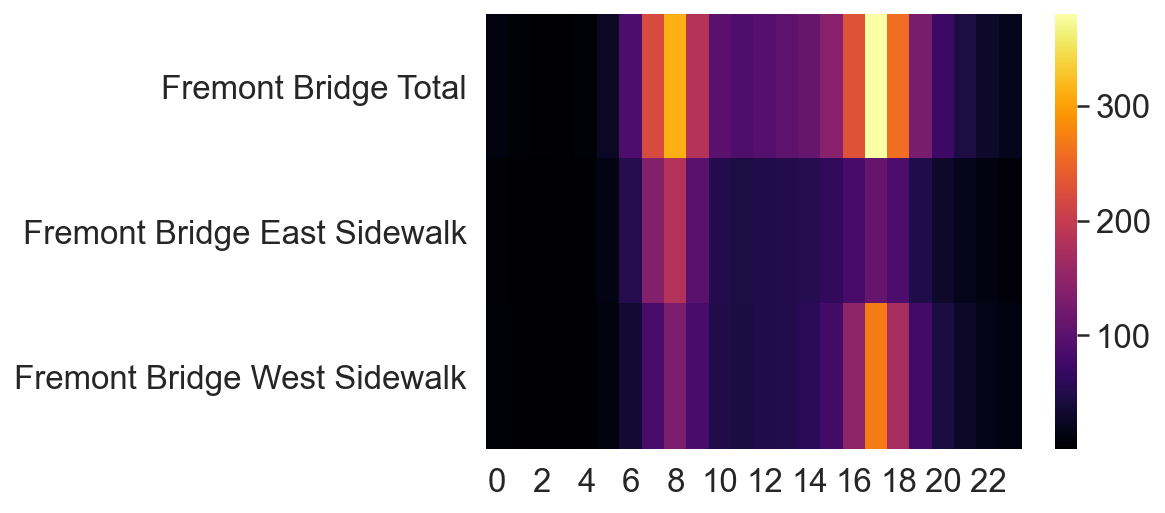

In [233]:
with sns.plotting_context('notebook', font_scale=1.5):
    sns.heatmap(data.groupby(data.index.hour).mean().T, cmap='inferno')
    plt.xlabel('')
    

<AxesSubplot:xlabel='time'>

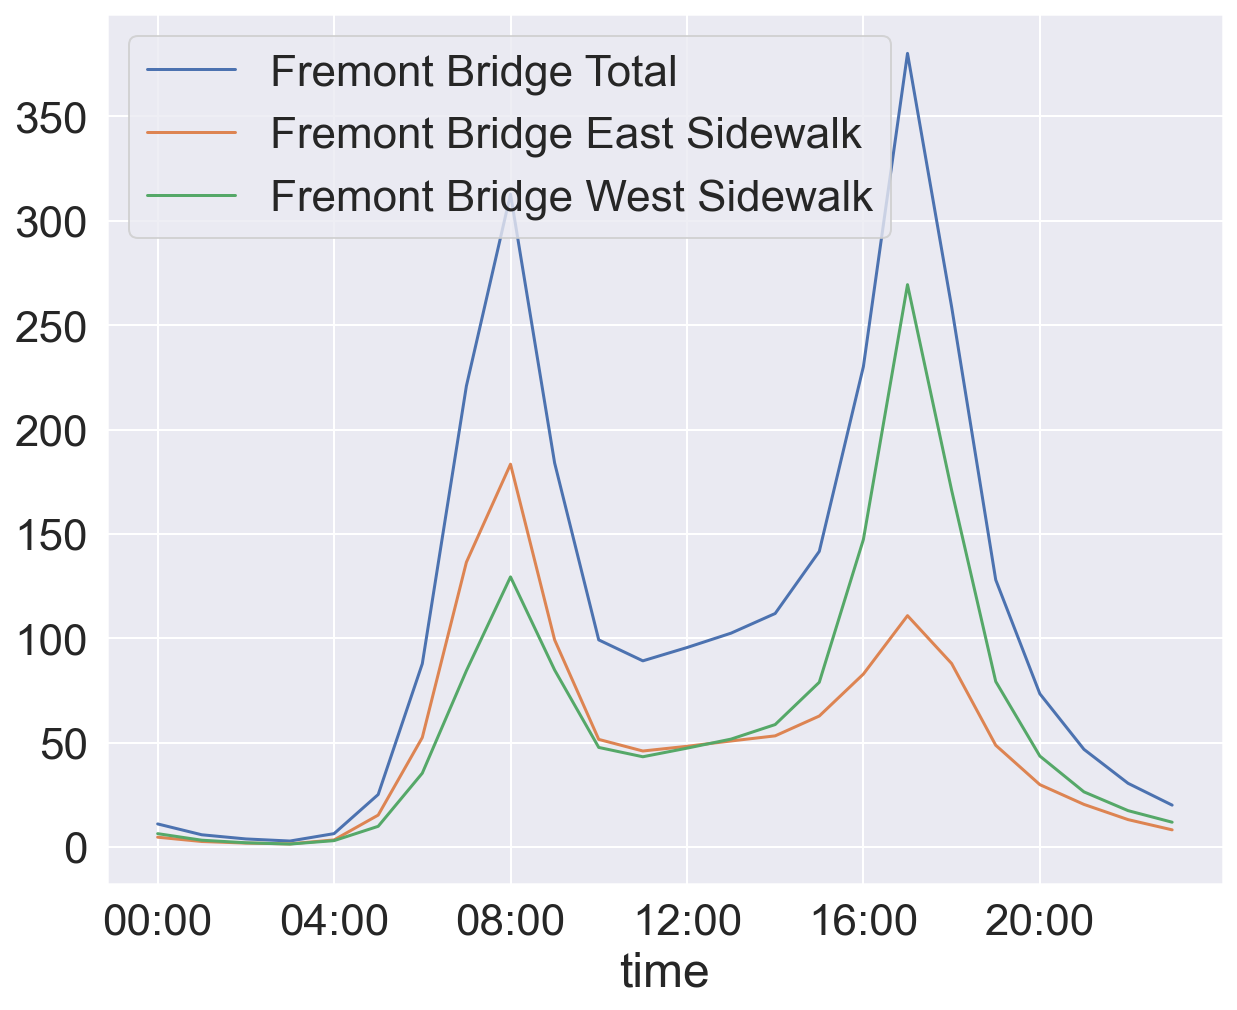

In [230]:
fig, ax = plt.subplots(figsize=(10,8))

hourly_ticks = 4 * 60 * 60 * np.arange(6)
data.groupby(data.index.time).mean().plot(ax = ax, xticks=hourly_ticks)


In [234]:
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.time]).mean()